# Poly case

In [1]:
import numpy as np
import pandas as pd

np.set_printoptions(suppress=True)
rng = np.random.default_rng()

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams.update({"font.size": 10})
from ipywidgets import interact
import ipywidgets as widgets

from p_tqdm import p_map

from scipy.ndimage import gaussian_filter

import iterative_ensemble_smoother as ies

In [2]:
%load_ext autoreload
%autoreload 2
from dass import pde, utils, analysis, taper

In [3]:
N = 100

In [4]:
def poly(a, b, c, x):
    return a * x**2 + b * x + c

In [5]:
import numpy as np

rng = np.random.default_rng(12345)

a_t = 0.5
b_t = 1.0
c_t = 3.0


def p(x):
    return a_t * x**2 + b_t * x + c_t


x_observations = [0, 2, 4, 6, 8]
observations = [
    (p(x) + rng.normal(loc=0, scale=0.1 * p(x)), 0.1 * p(x), x) for x in x_observations
]
# observations = [(p(x) + rng.normal(loc=0, scale=0.1), 0.1, x) for x in x_observations]

d = pd.DataFrame(observations, columns=["value", "sd", "x"])

d = d.set_index("x")

m = d.shape[0]

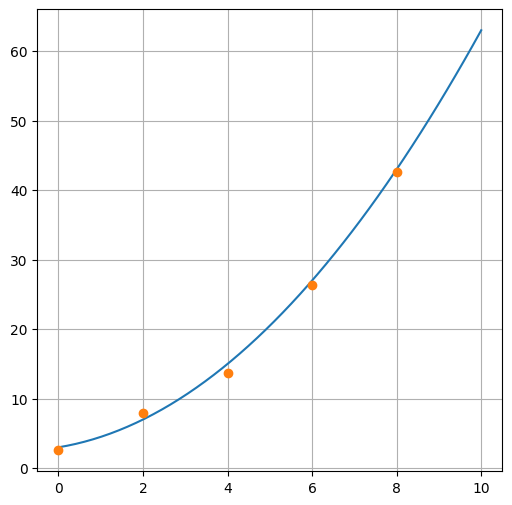

In [6]:
fig, ax = plt.subplots()
x_plot = np.linspace(0, 10, 50)
ax.plot(x_plot, poly(a_t, b_t, c_t, x_plot))
ax.plot(d.index.get_level_values("x"), d.value.values, "o")
ax.grid()

In [7]:
# Assume diagonal ensemble covariance matrix for the measurement perturbations.
# Is this a big assumption?
Cdd = np.diag(d.sd.values**2)

# 9.4 Ensemble representation for measurements
E = rng.multivariate_normal(mean=np.zeros(len(Cdd)), cov=Cdd, size=N).T
E = E - E.mean(axis=1, keepdims=True)
assert E.shape == (m, N)

# We will not use the sample covariance Cee, and instead use Cdd directly.
# It is not clear to us why Cee is proposed used.
# Cee = (E @ E.T) / (N - 1)

D = np.ones((m, N)) * d.value.values.reshape(-1, 1) + E

In [8]:
coeff_a = rng.uniform(-1, 1, size=N)
coeff_b = rng.uniform(-2, 2, size=N)
coeff_c = rng.uniform(-5, 5, size=N)

In [9]:
A = np.concatenate(
    (coeff_a.reshape(-1, 1), coeff_b.reshape(-1, 1), coeff_c.reshape(-1, 1)), axis=1
).T

In [10]:
fwd_runs = p_map(
    poly,
    coeff_a,
    coeff_b,
    coeff_c,
    [np.arange(max(x_observations) + 1)] * N,
    desc=f"Running forward model.",
)

Running forward model.:   0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
Y = np.array(
    [fwd_run[d.index.get_level_values("x").to_list()] for fwd_run in fwd_runs]
).T

assert Y.shape == (
    m,
    N,
), "Measured responses must be a matrix with dimensions (number of observations x number of realisations)"

In [12]:
X = analysis.ES(Y, D, Cdd)
A_ES = A @ X

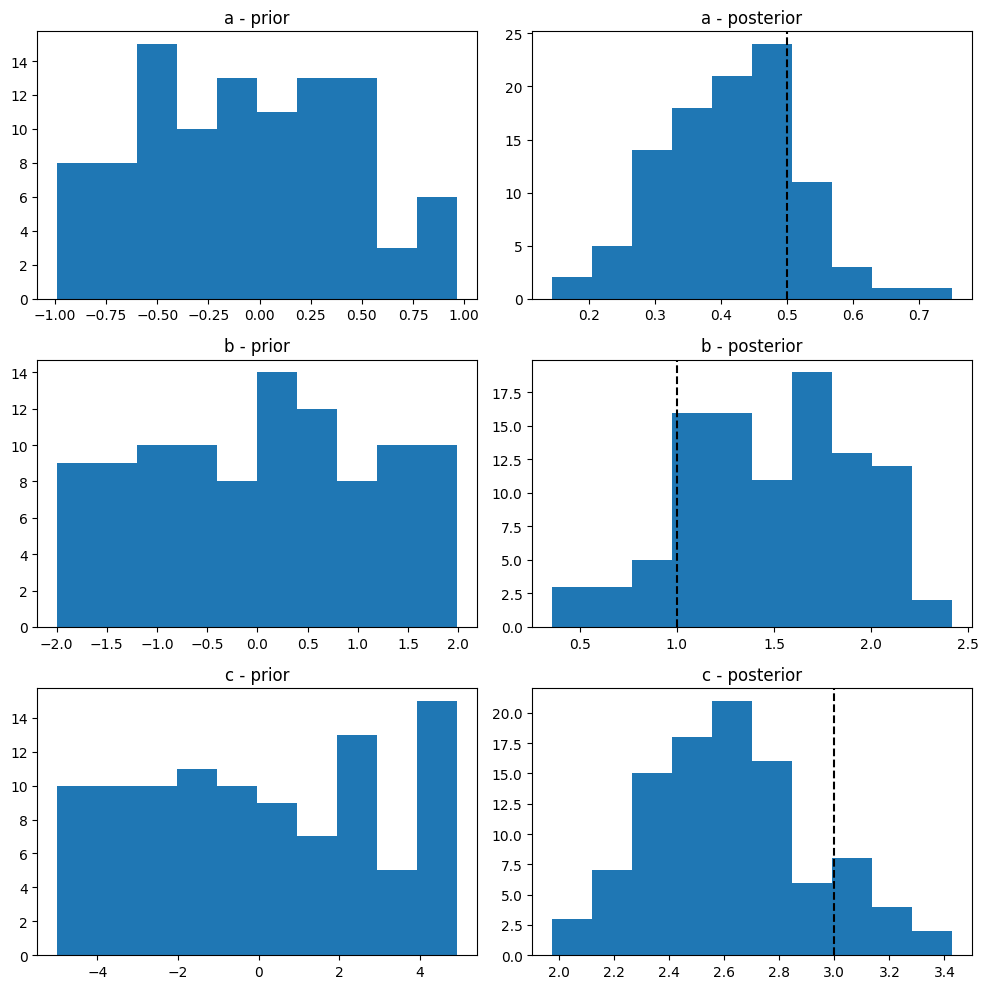

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(10, 10)

ax[0, 0].set_title("a - prior")
ax[0, 0].hist(A[0, :])

ax[0, 1].set_title("a - posterior")
ax[0, 1].hist(A_ES[0, :])
ax[0, 1].axvline(a_t, color="k", linestyle="--")

ax[1, 0].set_title("b - prior")
ax[1, 0].hist(A[1, :])

ax[1, 1].set_title("b - posterior")
ax[1, 1].hist(A_ES[1, :])
ax[1, 1].axvline(b_t, color="k", linestyle="--")

ax[2, 0].set_title("c - prior")
ax[2, 0].hist(A[2, :])

ax[2, 1].set_title("c - posterior")
ax[2, 1].hist(A_ES[2, :])
ax[2, 1].axvline(c_t, color="k", linestyle="--")

fig.tight_layout()